In [ ]:
#Iniziamo

In [ ]:
!pip install transformers datasets torch torchvision

from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import csv
from PIL import Image
from torch.utils.data import Dataset
import torch
import numpy as np
from torchvision.transforms import Compose, Resize, Normalize
from torchvision.transforms.functional import InterpolationMode

class DatasetCVUSASegmentation(Dataset):
    def __init__(self, list_path, root_dir, transform_img=None, transform_mask=None, color_to_class_fn=None, base_colors=None):
        self.root_dir = root_dir
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.color_to_class_fn = color_to_class_fn
        self.colormap = np.array(list(base_colors.values()), dtype=np.uint8)  # Per decode
        self.image_ids = []

        with open(list_path, "r") as f:
            reader = csv.reader(f, delimiter=',')
            for row in reader:
                sat_path = row[0]
                filename = os.path.basename(sat_path)
                if filename.startswith("input"):
                    filename = filename[len("input"):]
                image_id = os.path.splitext(filename)[0]
                self.image_ids.append(image_id)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.root_dir, "bingmap", f"input{image_id}.png")
        mask_path = os.path.join(self.root_dir, "segmap", f"output{image_id}.png")

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        if self.transform_img:
            image = self.transform_img(image)

        if self.transform_mask:
            mask = self.transform_mask(mask)

        # 🎯 Converti la maschera RGB in mappa classi
        mask = encode_segmentation_fast(mask, self.color_to_class_fn).long()

        return image, mask


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def build_color_to_class_function(base_colors, tolerance=30):
    # Convert to array for easier computation
    color_array = np.array(list(base_colors.values()))
    color_labels = list(base_colors.keys())

    def color_to_class(rgb):
        rgb = np.array(rgb)
        dists = np.linalg.norm(color_array - rgb, axis=1)
        min_idx = np.argmin(dists)
        if dists[min_idx] <= tolerance:
            return min_idx  # Return class index
        else:
            return 255  # Unknown class (can be masked later)

    return color_to_class

In [ ]:
base_colors = {
    "white": (255, 255, 255),
    "red": (255, 0, 0),
    "green": (0, 255, 0),
    "blue": (0, 0, 255),
    "cyan": (0, 255, 255)
}
colormap = np.array(list(base_colors.values()), dtype=np.uint8)

In [ ]:
color_to_class_fn = build_color_to_class_function(base_colors, tolerance=30)

In [ ]:
def decode_segmentation(mask, colormap):
    return colormap[mask]  # Funziona se mask ha valori in [0, N) e colormap è np.array di shape [N, 3]

In [ ]:
def encode_segmentation(mask_rgb, colormap):
    mask_rgb = np.array(mask_rgb)
    class_mask = np.zeros(mask_rgb.shape[:2], dtype=np.int64)

    color_to_class = {tuple(color): idx for idx, color in enumerate(colormap)}

    for color, class_idx in color_to_class.items():
        matches = np.all(mask_rgb == color, axis=-1)
        class_mask[matches] = class_idx

    return torch.from_numpy(class_mask).long()

In [ ]:
def encode_segmentation_fast(mask, color_to_class_fn):
    mask_np = np.array(mask)
    flat_mask = mask_np.reshape(-1, 3)
    encoded_flat = np.array([color_to_class_fn(tuple(px)) for px in flat_mask], dtype=np.uint8)
    encoded = encoded_flat.reshape(mask_np.shape[:2])
    return torch.from_numpy(encoded)

In [ ]:
test_mask = Image.open("/content/drive/MyDrive/Dataset_Computer_Vision/Dataset_CVUSA/Dataset_CVUSA/segmap/output0000029.png").convert("RGB")
encoded = encode_segmentation(test_mask, {tuple(c): i for i, c in enumerate(colormap)})
print(torch.unique(encoded))

tensor([0, 1, 2, 3, 4])


In [ ]:
color_to_class_fn = build_color_to_class_function(base_colors, tolerance=30)

In [ ]:
mask_np = np.array(test_mask)
unique_colors = np.unique(mask_np.reshape(-1, 3), axis=0)
print(unique_colors[:10])  # Primi 10 colori trovati
print("Num unique:", len(unique_colors))


[[  0   0 254]
 [  0   0 255]
 [  0   1 253]
 [  0   1 255]
 [  0   2 252]
 [  0   2 255]
 [  0   3 251]
 [  0   3 255]
 [  0   4 250]
 [  0   4 255]]
Num unique: 2069


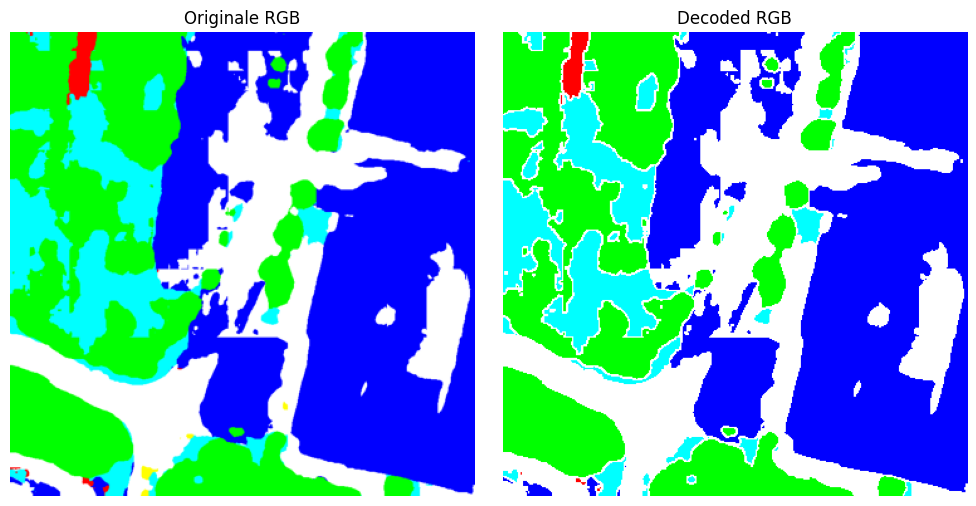

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Carica una maschera originale RGB
mask_path = "/content/drive/MyDrive/Dataset_Computer_Vision/Dataset_CVUSA/Dataset_CVUSA/segmap/output0000029.png"
original_mask = Image.open(mask_path).convert("RGB")

# Codifica -> classi
class_mask = encode_segmentation(original_mask, {tuple(c): i for i, c in enumerate(colormap)})

# Decodifica -> RGB
decoded_mask = decode_segmentation(class_mask.numpy(), colormap)

# Mostra: originale vs ricostruita
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(original_mask)
axs[0].set_title("Originale RGB")
axs[1].imshow(decoded_mask)
axs[1].set_title("Decoded RGB")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

def get_image_transform():
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

# Trasformazione per la maschera
def get_mask_transform():
    return transforms.Compose([
        transforms.Resize((64, 64), interpolation=Image.NEAREST)
        # Nessun ToTensor qui: la conversione a tensor la fai a mano dopo aver verificato la dimensione
    ])

img_transform = get_image_transform()
mask_transform = get_mask_transform()

dataset = DatasetCVUSASegmentation(
    list_path="/content/drive/MyDrive/Dataset_Computer_Vision/Dataset_CVUSA/Dataset_CVUSA/train_seg-19zl.csv",
    root_dir="/content/drive/MyDrive/Dataset_Computer_Vision/Dataset_CVUSA/Dataset_CVUSA/",
    transform_img=img_transform,
    transform_mask=mask_transform,
    color_to_class_fn=color_to_class_fn,
    base_colors=base_colors
)

dataloader = DataLoader(dataset, batch_size=6, shuffle=True, num_workers=2)

In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import torch

# Define the path to your saved model weights
model_weights_path = "segformer_cvusa_seg6.pth"

# Define the base SegFormer model architecture used for pretraining
# IMPORTANT: Replace "nvidia/segformer-b0-finetuned-ade-512-512" with the actual base model you used
base_model_architecture = "nvidia/segformer-b3-finetuned-ade-512-512"

# Load the base model architecture from Hugging Face
# We set num_labels to the number of classes in your dataset
model = SegformerForSemanticSegmentation.from_pretrained(
    base_model_architecture,
    num_labels=len(colormap),  # Assuming colormap contains all your classes
    ignore_mismatched_sizes=True  # This is important if the number of classes is different
)

# Load your saved state dictionary
state_dict = torch.load(model_weights_path, map_location=torch.device('cpu')) # Load to CPU first

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Load the feature extractor for the base model
feature_extractor = SegformerFeatureExtractor.from_pretrained(base_model_architecture)

# Set the model to evaluation mode and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

print("Model loaded successfully with your custom weights.")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([5, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully with your custom weights.


/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

dataset_root = "/content/drive/MyDrive/Dataset_Computer_Vision/Dataset_CVUSA/Dataset_CVUSA"
image_paths = [os.path.join(dataset_root, f) for f in os.listdir(dataset_root) if f.endswith(('.jpg', '.png'))]


In [ ]:
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss(ignore_index=255)

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch

# Hyperparametri
epochs = 10
lr = 3e-5  # learning rate iniziale

optimizer = AdamW(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',       # cerca di minimizzare la loss
    factor=0.5,       # riduce il LR del 50%
    patience=3,       # aspetta 3 epoche senza miglioramento
    verbose=True      # stampa quando cambia il LR
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assicurati che il modello sia sul device
model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=images).logits  # [B, C, H, W]
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)

    # 🔁 Step del scheduler con la loss media dell'epoca
    scheduler.step(avg_loss)

    # 🔍 (opzionale) stampa learning rate corrente
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - LR: {current_lr:.6f}")


Epoch 1/10 - Loss: 0.0983 - LR: 0.000030
Epoch 2/10 - Loss: 0.0977 - LR: 0.000030
Epoch 3/10 - Loss: 0.0951 - LR: 0.000030
Epoch 4/10 - Loss: 0.0951 - LR: 0.000030
Epoch 5/10 - Loss: 0.0947 - LR: 0.000030
Epoch 6/10 - Loss: 0.0940 - LR: 0.000030
Epoch 7/10 - Loss: 0.0935 - LR: 0.000030
Epoch 8/10 - Loss: 0.0931 - LR: 0.000030
Epoch 9/10 - Loss: 0.0928 - LR: 0.000030
Epoch 10/10 - Loss: 0.0928 - LR: 0.000030


In [ ]:
torch.save(model.state_dict(), "segformer_cvusa_seg7.pth")

In [ ]:
!cp segformer_cvusa_seg7.pth /content/drive/MyDrive/

In [ ]:
import torch
import os
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

backbone = "nvidia/segformer-b3-finetuned-ade-512-512"

model = SegformerForSemanticSegmentation.from_pretrained(
    backbone,
    num_labels=5,  # o il tuo valore
    ignore_mismatched_sizes=True  # utile se hai cambiato num_labels
)

# Ora carichi i tuoi pesi fine-tunati
state_dict = torch.load("segformer_cvusa_seg6.pth", map_location="cpu")
model.load_state_dict(state_dict)

# Invia su GPU (o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

save_dir = "predictions"           # dove salvare le immagini
os.makedirs(save_dir, exist_ok=True)

# === FEATURE EXTRACTOR PER NORMALIZZAZIONE ===
feature_extractor = SegformerFeatureExtractor.from_pretrained(backbone)

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# === UTILITY PER COLORARE LA MASCHERA ===
import numpy as np

# === INFERENZA SU IMMAGINI DI TEST ===
img_path="/content/drive/MyDrive/Dataset_Computer_Vision/Dataset_CVUSA/Dataset_CVUSA/bingmap/input0000029.png"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


orig_img = Image.open(img_path).convert("RGB")
input_tensor = transform(orig_img).unsqueeze(0).to(device)

# Forward pass
with torch.no_grad():
    outputs = model(pixel_values=input_tensor)
logits = outputs.logits  # [1, num_classes, H, W]
pred_mask = torch.argmax(logits.squeeze(), dim=0).cpu().numpy().astype(np.uint8)

# Salva maschera colorata
colored_mask = decode_segmentation(pred_mask, dataset.colormap)
mask_img = Image.fromarray(colored_mask.astype(np.uint8))
mask_img = mask_img.resize(orig_img.size, resample=Image.NEAREST)

# Sovrapposizione (overlay)
overlay = Image.blend(orig_img, mask_img, alpha=0.5)

# Salva output
base_name = os.path.splitext(os.path.basename(img_path))[0]
mask_img.save(os.path.join(save_dir, f"{base_name}_mask.png"))
overlay.save(os.path.join(save_dir, f"{base_name}_overlay.png"))


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([5, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
